# Template matching

This notebook shows an example of how to align a stack of images based on a template which is present throughout the entire stack.

In [14]:
import pyclesperanto as cle
from skimage.io import imread
import numpy as np
import scipy.ndimage as ndi
import random
from matplotlib import pyplot as plt

In [15]:
cle.select_device()

(OpenCL) NVIDIA GeForce RTX 4090 (OpenCL 3.0 CUDA)
	Vendor:                      NVIDIA Corporation
	Driver Version:              535.216.01
	Device Type:                 GPU
	Compute Units:               128
	Global Memory Size:          24217 MB
	Maximum Object Size:         6054 MB
	Max Clock Frequency:         2625 MHz
	Image Support:               Yes

## Create example data

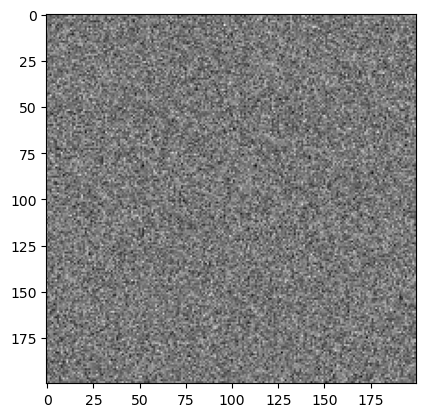

In [28]:
# create example data
unaligned_stack = np.random.normal(size=(50, 200, 200))
plt.imshow(unaligned_stack[25], cmap='gray')

In [17]:
# add a white box in a random location to each image in the stack
BOX_SIZE = 20
image_shape = unaligned_stack[0].shape

for i in range(len(unaligned_stack)):
    
    if i == 0:
        # place the box in the centre of the first image
        offset_x = image_shape[0] // 2 - BOX_SIZE // 2
        offset_y = image_shape[1] // 2 - BOX_SIZE // 2
    else:
        offset_x = int(random.random() * (image_shape[0]-BOX_SIZE))
        offset_y = int(random.random() * (image_shape[1]-BOX_SIZE))
        
    unaligned_stack[i, offset_x:offset_x+BOX_SIZE, offset_y:offset_y+BOX_SIZE] = 5

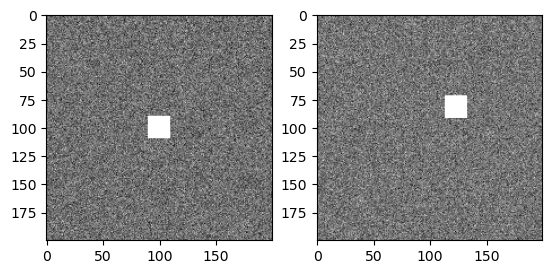

In [26]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(unaligned_stack[0], cmap='gray')
axs[1].imshow(unaligned_stack[1], cmap='gray')

## Align images

Template matching translates images in the x and y directions to align each image based on a common subimage. In this example, the images can be aligned based on the white square in the first image.

First, we must define a template to search for within each image. We can crop the white square in the first image to be used as our template.

min: 5.0 max: 5.0


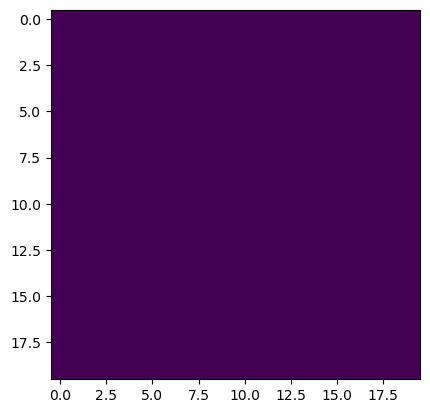

In [ ]:
template = unaligned_stack[0, 90:110, 90:110]
print("min:",template.min(), "max:",template.max())
plt.imshow(template, cmap='gray')


Next, we can use cross correlation to search for the template within each image. The location of the maximum value in this array should give the location of the template in the image.

We can obtain the template location for the first image which we can use to calculate the offsets required to centre the remaining images.

base_location: (np.int64(100), np.int64(100))


array([[-0.12628879, -0.10267503, -0.10696819, ...,  0.27568197,
         0.30740392,  0.3334    ],
       [-0.14022419, -0.1182413 , -0.11958323, ...,  0.25650507,
         0.2871662 ,  0.31465533],
       [-0.13830975, -0.11377283, -0.11129494, ...,  0.2170777 ,
         0.24697357,  0.26945457],
       ...,
       [-0.20637684, -0.19254513, -0.22057651, ...,  0.01174233,
        -0.01713795, -0.02706544],
       [-0.2547566 , -0.2344075 , -0.25912064, ...,  0.02673195,
        -0.00585403, -0.02164675],
       [-0.26078826, -0.24327216, -0.27202418, ...,  0.0412375 ,
         0.00730568, -0.0161858 ]], dtype=float32, mtype=buffer)
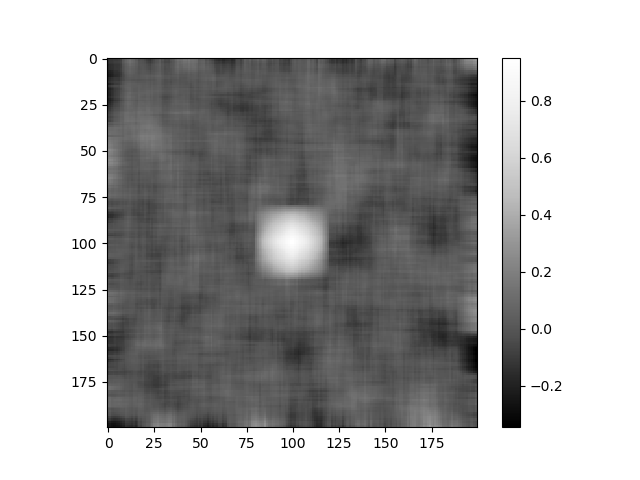
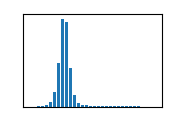

In [20]:
ccorr = cle.local_cross_correlation(unaligned_stack[0], template)
ccorr = cle.undefined_to_zero(ccorr)
base_location = ndi.maximum_position(ccorr)
print(f"base_location: {base_location}")
ccorr

Finally, we can calculate the location of the template within the remaining images and use a transformation to align them.

In [21]:
aligned_stack = np.zeros(unaligned_stack.shape)
for i in range(0, len(unaligned_stack)):
    # calculate the cross correlation for the given image and template
    ccorr = cle.local_cross_correlation(unaligned_stack[i], template)
    
    # obtain the location of the template within the image
    location = ndi.maximum_position(ccorr)

    # calculate the offsets using the location of the template in the first image
    offset_x = base_location[1] - location[1]
    offset_y = base_location[0] - location[0]
    
    # transform the images using the given offsets
    aligned_slice = cle.translate(unaligned_stack[i], translate_x=offset_x, translate_y=offset_y)
    aligned_stack[i, :, :] = aligned_slice.get()

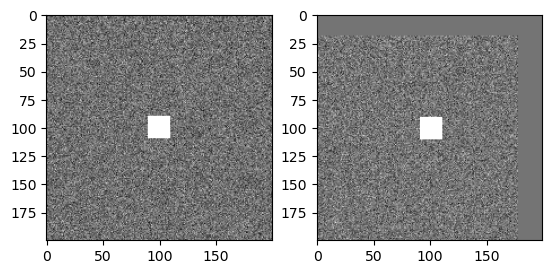

In [ ]:
# show the aligned images
fig, axs = plt.subplots(1, 2)
axs[0].imshow(aligned_stack[0], cmap='gray')
axs[1].imshow(aligned_stack[1], cmap='gray')